In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import scipy.signal
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
class ZENITH(object):
    def __init__(self, aerodb, x0=None, rho=None):
        self.aerodb = aerodb
        self.x0 = x0
        self.rho = rho
        self.x_l = [self.x0]
        self.t_l = [0]
        
    @property
    def aerodb(self):
        return self._aerodb
    
    @aerodb.setter
    def aerodb(self, aerodb):
        self._aerodb = aerodb
        
    @property
    def x(self):
        return self._x
    
    @x.setter
    def x(self, x):
        self._x = x
        
    @property
    def xE(self):
        R = 6378.15e3
        x1, x2, x3 = self.pos
        xE = np.array([
            [R*np.arctan(np.sqrt(x1**2 + x3**2)/(R+x2))*(x1/np.sqrt(x1**2 + x3**2))],
            [np.sqrt((R+x2)**2 + (x1**2 + x3**2) - R)],
            [R*np.arctan(np.sqrt(x1**2 + x3**2)/(R+x2))*(x3/np.sqrt(x1**2 + x3**2))]
        ])
        
        return xE
        
    @property
    def pos(self):
        return self.x[:3]
    
    @property
    def vel(self):
        return self.x[3:6]
    
    @property
    def ang(self):
        return self.x[6:9]
    
    @property
    def angvel(self):
        return self.x[9:]
        
    @property
    def x0(self):
        return self._x0
    
    @x0.setter
    def x0(self, x0):
        if x0 is None:
            x0 = np.zeros((12,1))
        else:
            pass
        
        try:
            x0.shape
        except:
            raise TypeError("Initial state x0 must be a numpy array.")
        else:
            if x0.shape[0] != 1:
                x0 = x0.reshape((x0.shape[0],1))
            else:
                pass

            if x0.shape[0] != 12:
                raise ValueError("Initial state x0 must a full state (12-row) vector.")
            else:
                self.x = x0
                self._x0 = x0
                
    def set_rho(self, rho):
        if rho is None:
            self._rho = lambda h : 1.225
        elif callable(rho):
            self._rho = rho
        elif isinstance(rho, float):
            self._rho = lambda h : rho
        else:
            raise TypeError("Invalid rho type")
            
    def set_I(self, I, t_I):
        Idot = np.gradient(I, t_I)

        self._Ifunct = lambda t : np.interp(t, t_I, I)
        self._Idotfunct = lambda t : np.interp(t, t_I, Idot)
        
    def get_I(self, t):
        return self._Ifunct(t)
    
    def get_Idot(self, t):
        return self._Idotfunct(t)
    
    def set_Ip(self, Ip, t_Ip):
        Ipdot = np.gradient(Ip, t_Ip)

        self._Ipfunct = lambda t : np.interp(t, t_Ip, Ip)
        self._Ipdotfunct = lambda t : np.interp(t, t_Ip, Ipdot)
        
    def get_Ip(self, t):
        return self._Ipfunct(t)
    
    def get_Ipdot(self, t):
        return self._Ipdotfunct(t)
            
    def yaw(self, Vw=None):
        if Vw is None:
            Vw = np.zeros((3,1))
        else:
            pass
        
        posDOTvelw = self.pos.flatten().dot((self.vel+Vw).flatten())
        PosMULVelW = np.linalg.norm(self.pos)*np.linalg.norm(self.vel+Vw)
        
        yaw = np.arccos(posDOTvelw/PosMULVelW)
        
        if np.isnan(yaw):
            yaw = 0
        
        return yaw
        
    def rho(self, h=0):
        return self._rho(h)
                
    def xdot(self, t, x):
        self.x = x
        self.x_l.append(x) 
        self.t_l.append(t)
        
        z = self.x[2]
        rho = self.rho(z)
        I = self.get_I(t)
        Ip = self.get_Ip(t)
        IDIVIp = I/Ip
        
        self.aerodb

$$\frac{\pi}{4} d^2 = S^2$$

$$\frac{1}{2} \rho C S = \rho K d^2$$

$$K = \frac{C S}{2 d^2}$$

$$C = \frac{2 K d^2}{S}$$

In [14]:
class AeroDB(object):
    def __init__(self, aerodb=None, cal=1, area=None):
        if isinstance(aerodb, AeroDB):
            self.clone(aerodb)
        else:
            self.clear()
        
        if cal is None and area is None:
            raise ValueError("Provide at least one of caliber and area as dimensional input.")
        elif area is None:
            self.cal = cal
            self.area = area
        else:
            self.area = area
            self.cal = cal
            
        self.eps = 0
        self.m = 0
        self.rho = 1.225
        self.transverseInertiaCurve = None
        self.polarInertiaCurve = None
        self.transverseInertiaRateCurve = None
        self.polarInertiaRateCurve = None
            
        
    def clear(self):
        self.cal = 1
        self.area = None
        self.KD0 = 0
        self.KDa = 0
        
    def C2K(self, C):
        return C*self.area/(2*self.cal**2)
    
    def K2C(self, K):
        return (2*K*self.cal**2)/self.area
        
    @property
    def area(self):
        return self._area
    
    @area.setter
    def area(self, area):
        if area is None:
            self._area = np.sqrt(np.pi)*self.cal/2
        elif np.isscalar(area):
            area = np.abs(area)
            self._area = area
        else:
            raise TypeError("Area must be a scalar.")
        
    @property
    def cal(self):
        return self._cal
    
    @cal.setter
    def cal(self, cal):
        if cal is None:
            self._cal = 2*self.area/np.sqrt(np.pi)
        elif np.isscalar(cal):
            cal = np.abs(cal)
            self._cal = cal
        else:
            raise TypeError("Caliber must be a scalar.")
        
    @property
    def KD0(self):
        return self._KD0
    
    @KD0.setter
    def KD0(self, KD0):
        if np.isscalar(KD0):
            KD0 = np.abs(KD0)
            self._KD0 = KD0
        else:
            raise TypeError("Zero-lift drag force coefficient KD0 (AB) must be a scalar.")
            
    @property
    def CD0(self):
        return self.K2C(self.KD0)
    
    @CD0.setter
    def CD0(self, CD0):
        if np.isscalar(CD0):
            CD0 = np.abs(CD0)
            self.KD0 = self.C2K(CD0)
        else:
            raise TypeError("Zero-lift drag force coefficient CD0 (AD) must be a scalar.")
    
    @property
    def KDa(self):
        return self._KDa
    
    @KDa.setter
    def KDa(self, KDa):
        if np.isscalar(KDa):
            KDa = KDa
            self._KDa = KDa
        else:
            raise TypeError("Angle-dep. drag force coefficient KDa (AB) must be a scalar.")
            
    @property
    def CDa(self):
        return self.K2C(self.KDa)
    
    @CDa.setter
    def CDa(self, CDa):
        if np.isscalar(CDa):
            CDa = CDa
            self.KDa = self.C2K(CDa)
        else:
            raise TypeError("Angle-dep. drag force coefficient CDa (AD) must be a scalar.")
            
    @property
    def KDa2(self):
        return self._KDa2
    
    @KDa.setter
    def KDa2(self, KDa2):
        if np.isscalar(KDa2):
            KDa2 = KDa2
            self._KDa2 = KDa2
        else:
            raise TypeError("Square angle-dep. drag force coefficient KDa2 (AB) must be a scalar.")
            
    @property
    def CDa2(self):
        return self.K2C(self.KDa2)
    
    @CDa2.setter
    def CDa2(self, CDa2):
        if np.isscalar(CDa2):
            CDa2 = CDa2
            self.KDa2 = self.C2K(CDa2)
        else:
            raise TypeError("Square angle-dep. drag force coefficient CDa2 (AD) must be a scalar.")
            
    @property
    def KA(self):
        return self._KA
    
    @KA.setter
    def KA(self, KA):
        if np.isscalar(KA):
            KA = np.abs(KA)
            self._KA = KA
        else:
            raise TypeError("Spin damping moment coefficient KA (AB) must be a scalar.")
            
    @property
    def CA(self):
        return self.K2C(self.KA)
    
    @CA.setter
    def CA(self, CA):
        if np.isscalar(CA):
            CA = np.abs(CA)
            self.KA = self.C2K(CA)
        else:
            raise TypeError("Spin damping moment coefficient CA (AD) must be a scalar.")
            
    @property
    def KE(self):
        return self._KE
    
    @KE.setter
    def KE(self, KE):
        if np.isscalar(KE):
            KE = KE
            self._KE = KE
        else:
            raise TypeError("Fin cant moment coefficient KE (AB) must be a scalar.")
            
    @property
    def CE(self):
        return self.K2C(self.KE)
    
    @CE.setter
    def CE(self, CE):
        if np.isscalar(CE):
            CE = CE
            self.KE = self.C2K(CE)
        else:
            raise TypeError("Fin cant moment coefficient CE (AD) must be a scalar.")
            
    @property
    def KL(self):
        return self._KL
    
    @KL.setter
    def KL(self, KL):
        if np.isscalar(KL):
            KL = np.abs(KL)
            self._KL = KL
        else:
            raise TypeError("Lift force coefficient KL (AB) must be a scalar.")
            
    @property
    def CL(self):
        return self.K2C(self.KL)
    
    @CL.setter
    def CL(self, CL):
        if np.isscalar(CL):
            CL = np.abs(CL)
            self.KL = self.C2K(CL)
        else:
            raise TypeError("Lift force coefficient CL (AD) must be a scalar.")
            
    @property
    def KM(self):
        return self._KM
    
    @KM.setter
    def KM(self, KM):
        if np.isscalar(KM):
            KM = KM
            self._KM = KM
        else:
            raise TypeError("Overturning moment coefficient KM (AB) must be a scalar.")
            
    @property
    def CM(self):
        return self.K2C(self.KM)
    
    @CM.setter
    def CM(self, CM):
        if np.isscalar(CM):
            CM = CM
            self.KM = self.C2K(CM)
        else:
            raise TypeError("Overturning moment coefficient CM (AD) must be a scalar.")
            
    @property
    def KF(self):
        return self._KF
    
    @KF.setter
    def KF(self, KF):
        if np.isscalar(KF):
            KF = np.abs(KF)
            self._KF = KF
        else:
            raise TypeError("Magnus force coefficient KF (AB) must be a scalar.")
            
    @property
    def CF(self):
        return self.K2C(self.KF)
    
    @CF.setter
    def CF(self, CF):
        if np.isscalar(CF):
            CF = np.abs(CF)
            self.KF = self.C2K(CF)
        else:
            raise TypeError("Magnus force coefficient CF (AD) must be a scalar.")
            
    @property
    def KT(self):
        return self._KT
    
    @KT.setter
    def KT(self, KT):
        if np.isscalar(KT):
            KT = np.abs(KT)
            self._KT = KT
        else:
            raise TypeError("Magnus moment coefficient KT (AB) must be a scalar.")
            
    @property
    def CT(self):
        return self.K2C(self.KT)
    
    @CT.setter
    def CT(self, CT):
        if np.isscalar(CT):
            CT = np.abs(CT)
            self.KT = self.C2K(CT)
        else:
            raise TypeError("Magnus moment coefficient CT (AD) must be a scalar.")
            
    @property
    def KS(self):
        return self._KS
    
    @KS.setter
    def KS(self, KS):
        if np.isscalar(KS):
            KS = np.abs(KS)
            self._KS = KS
        else:
            raise TypeError("Pitching force coefficient KS (AB) must be a scalar.")
            
    @property
    def CS(self):
        return self.K2C(self.KS)
    
    @CS.setter
    def CS(self, CS):
        if np.isscalar(CS):
            CS = np.abs(CS)
            self.KS = self.C2K(CS)
        else:
            raise TypeError("Pitching force coefficient CS (AD) must be a scalar.")
            
    @property
    def KH(self):
        return self._KH
    
    @KH.setter
    def KH(self, KH):
        if np.isscalar(KH):
            KH = KH
            self._KH = KH
        else:
            raise TypeError("Damping moment coefficient KH (AB) must be a scalar.")
            
    @property
    def CH(self):
        return self.K2C(self.KH)
    
    @CH.setter
    def CH(self, CH):
        if np.isscalar(CH):
            CH = CH
            self.KH = self.C2K(CH)
        else:
            raise TypeError("Damping moment coefficient CH (AD) must be a scalar.")
            
    @property
    def KXF(self):
        return self._KXF
    
    @KXF.setter
    def KXF(self, KXF):
        if np.isscalar(KXF):
            KXF = np.abs(KXF)
            self._KXF = KXF
        else:
            raise TypeError("Magnus cross force coefficient KXF (AB) must be a scalar.")
            
    @property
    def CXF(self):
        return self.K2C(self.KXF)
    
    @CXF.setter
    def CXF(self, CXF):
        if np.isscalar(CXF):
            CXF = np.abs(CXF)
            self.KXF = self.C2K(CXF)
        else:
            raise TypeError("Magnus cross force coefficient CXF (AD) must be a scalar.")
            
    @property
    def KXT(self):
        return self._KXT
    
    @KXT.setter
    def KXT(self, KXT):
        if np.isscalar(KXT):
            KXT = np.abs(KXT)
            self._KXT = KXT
        else:
            raise TypeError("Magnus cross moment coefficient KXT (AB) must be a scalar.")
            
    @property
    def CXT(self):
        return self.K2C(self.KXT)
    
    @CXT.setter
    def CXT(self, CXT):
        if np.isscalar(CXT):
            CXT = np.abs(CXT)
            self.KXT = self.C2K(CXT)
        else:
            raise TypeError("Magnus cross moment coefficient CXT (AD) must be a scalar.")
            
    def yaw(self, x, v):
        xDOTv = x.flatten().dot(v.flatten())
        XMULV = np.linalg.norm(x)*np.linalg.norm(v)
        
        yaw = np.arccos(xDOTv/XMULV)
        
        if np.isnan(yaw):
            yaw = 0
        
        return yaw
    
    def Rtilde(self, x, h, IDIVIp):
        hDOTx = h.flatten().dot(x.flatten())
        
        return IDIVIp*hDOTx
    
    @property
    def thrustCurve(self):
        return self._T
    
    @thrustCurve.setter
    def thrustCurve(self, T):
        if T is None:
            self._T = None
        else:
            try:
                T.shape
            except:
                raise TypeError("Thrust curve must be a numpy array.")
            else:
                if T.shape[1] != 2:
                    raise ValueError("Thrust curve must have a time and thrust force column.")
                else:
                    self._T = T
                    
    def thrustForce(self, t):
        if self.thrustCurve is not None:
            T = np.interp(t, self._T[:,0], self._T[:,1])
        else:
            T = 0
        
        Tvec = np.array([[T],
                         [0],
                         [0]])
        
        return Tvec
    
    @property
    def transverseInertiaCurve(self):
        return self._I
    
    @transverseInertiaCurve.setter
    def transverseInertiaCurve(self, I):
        if I is None:
            self._I = None
        else:
            try:
                I.shape
            except:
                raise TypeError("Transverse inertia curve must be a numpy array.")
            else:
                if I.shape[1] != 2:
                    raise ValueError("Transverse inertia curve must have a time and thrust force column.")
                else:
                    self._I = I
    
    def transverseInertia(self, t):
        if self.transverseInertiaCurve is not None:
            I = np.interp(t, self._I[:,0], self._I[:,1])
        else:
            I = 0
        
        return I
    
    @property
    def transverseInertiaRateCurve(self):
        return self._Idot
    
    @transverseInertiaRateCurve.setter
    def transverseInertiaRateCurve(self, Idot):
        if Idot is None:
            self._Idot = None
        else:
            try:
                Idot.shape
            except:
                raise TypeError("Transverse inertia rate curve must be a numpy array.")
            else:
                if Idot.shape[1] != 2:
                    raise ValueError("Transverse inertia rate curve must have a time and thrust force column.")
                else:
                    self._Idot = Idot
    
    def transverseInertiaRate(self, t):
        if self.transverseInertiaRateCurve is not None:
            Idot = np.interp(t, self._Idot[:,0], self._Idot[:,1])
        else:
            Idot = 0
        
        return Idot
    
    @property
    def transverseInertiaCurve(self):
        return self._I
    
    @transverseInertiaCurve.setter
    def transverseInertiaCurve(self, I):
        if I is None:
            self._I = None
        else:
            try:
                I.shape
            except:
                raise TypeError("Transverse inertia curve must be a numpy array.")
            else:
                if I.shape[1] != 2:
                    raise ValueError("Transverse inertia curve must have a time and thrust force column.")
                else:
                    self._I = I
    
    def transverseInertia(self, t):
        if self.transverseInertiaCurve is not None:
            I = np.interp(t, self._I[:,0], self._I[:,1])
        else:
            I = 0
        
        return I
    
    @property
    def polarInertiaRateCurve(self):
        return self._Ipdot
    
    @polarInertiaRateCurve.setter
    def polarInertiaRateCurve(self, Ipdot):
        if Ipdot is None:
            self._Ipdot = None
        else:
            try:
                Ipdot.shape
            except:
                raise TypeError("Polar inertia rate curve must be a numpy array.")
            else:
                if Ipdot.shape[1] != 2:
                    raise ValueError("Polar inertia rate curve must have a time and thrust force column.")
                else:
                    self._Ipdot = Ipdot
    
    def polarInertiaRate(self, t):
        if self.polarInertiaRateCurve is not None:
            Ipdot = np.interp(t, self._Ipdot[:,0], self._Ipdot[:,1])
        else:
            Ipdot = 0
        
        return Ipdot
    
    def densityCurve(self, rho):
        if rho is callable:
            self._rho = rho
        else:
            self._rho = lambda h : rho
      
    def density(self, h):
        return self._rho(h)
            
    def dragForce(self, x, v, rho=1.225):
        V = np.linalg.norm(v)
        yaw = self.yaw(x, v)
        
        return -rho*self.cal**2 * (self.KD0 + self.KDa*yaw + self.KDa2*yaw**2)*V*v
    
    def spindampingMoment(self, x, v, h, IDIVIp, rho=1.225):
        V = np.linalg.norm(v)
        Rtilde = self.Rtilde(x, h, IDIVIp)
        
        return -rho*self.cal**4 * self.KA * Rtilde * V * x
    
    def fincantMoment(self, x, v, eps=0, rho=1.225):
        V = np.linalg.norm(v)
        
        return -rho*self.cal**3 * self.KE * eps * V**2 * x
    
    def liftForce(self, x, v, rho=1.225):
        V = np.linalg.norm(v)
        vDOTx = v.flatten().dot(x.flatten())
        
        return rho*self.cal**2 * self.KL * (V**2 * x - vDOTx*v)
    
    def overturningMoment(self, x, v, rho=1.225):
        V = np.linalg.norm(v)
        vCRSx = np.cross(v.flatten(), x.flatten()).reshape((3,1))
        
        return rho*self.cal**3 * self.KM * V * vDOTx
    
    def magnusForce(self, x, v, h, IDIVIp, rho=1.225):
        xCRSv = np.cross(x.flatten(), v.flatten()).reshape((3,1))
        Rtilde = self.Rtilde(x, h, IDIVIp)
        
        return rho*self.cal**3 * self.KF * Rtilde * xCRSv
    
    def magnusMoment(self, x, v, h, IDIVIp, rho=1.225):
        vDOTx = v.flatten().dot(x.flatten())
        Rtilde = self.Rtilde(x, h, IDIVIp)
        
        return rho*self.cal**4 * self.KT * Rtilde * (xDOTv*x - v)
    
    def pitchingForce(self, x, v, h, rho=1.225):
        V = np.linalg.norm(v)
        hCRSx = np.cross(h.flatten(), x.flatten()).reshape((3,1))
        
        return -rho*self.cal**3 * self.KS * V * hCRSx
    
    def dampingMoment(self, x, v, h, rho=1.225):
        V = np.linalg.norm(v)
        hDOTx = h.flatten().dot(x.flatten())
        
        return -rho*self.cal**4 * self.KH * V * (h - hDOTx*x)
    
    def magnuscrossForce(self, x, v, h, IDIVIp, rho=1.225):
        V = np.linalg.norm(v)
        hDOTx = h.flatten().dot(x.flatten())
        Rtilde = self.Rtilde(x, h, IDIVIp)
        
        return rho*self.cal**4 * self.KXF * Rtilde * V * (h - hDOTx*x)
    
    def magnuscrossMoment(self, x, v, h, IDIVIp, rho=1.225):
        V = np.linalg.norm(v)
        hCRSx = np.cross(h.flatten(), x.flatten()).reshape((3,1))
        Rtilde = self.Rtilde(x, h, IDIVIp)
        
        return -rho*self.cal**5 * self.KXT * Rtilde * hCRSx
    
    def linacc(self, t, y):
        x = y[:3].reshape((3,1))
        v = y[3:6].reshape((3,1))
        o = y[6:9].reshape((3,1))
        h = y[9:].reshape((3,1))
        
        m = self.m
        rho = self.density(x[2])
        
        I = self.transverseInertia(t)
        Idot = self.transverseInertiaRate(t)
        Ip = self.polarInertia(t)
        Ipdot = self.polarInertiaRate(t)
        
        IDIVIp = I/Ip
        hCRSx = np.cross(h.flatten(), x.flatten()).reshape((3,1))
        
        F = self.thrustForce(t) + self.dragForce(x, v, rho=rho) + self.liftForce(x, v, rho=rho) \
            + self.magnusForce(x, v, h, IDIVIp, rho=rho) + self.pitchingForce(x, v, h, rho=rho) \
            + self.magnuscrossForce(x, v, h, IDIVIp, rho=rho) + (Idot/self.rt - self.mdot*self.re)*hCRSx
        
        vdot = F/m
        
        return vdot
        
    def angacc(self, t, y):
        x = y[:3].reshape((3,1))
        v = y[3:6].reshape((3,1))
        o = y[6:9].reshape((3,1))
        h = y[9:].reshape((3,1))
        
        m = self.m
        rho = self.density(x[2])
        eps = self.eps
        
        I = self.transverseInertia(t)
        Idot = self.transverseInertiaRate(t)
        Ip = self.polarInertia(t)
        Ipdot = self.polarInertiaRate(t)
        
        IDIVIp = I/Ip
        
        hdot = self.spindampingMoment(x, v, h, IDIVIp, rho=rho)/Ip + self.fincantMoment(x, v, eps=eps, rho=rho)/I \
            + self.overturningMoment(x, v, rho=rho)/I + self.magnusMoment(x, v, h, IDIVIp, rho=rho)/Ip \
            + self.dampingMoment(x, v, h, rho=rho)/I + self.magnuscrossMoment(x, v, h, IDIVIp, rho=rho)/Ip
        
        hDOTx = h.flatten().dot(x.flatten())
        
        hdot += -((Idot - self.mdot*self.re*self.rt)/I)*(h - hDOTx*x)
        
        return hdot
        
    def odefunc(self, t, y):
        x = y[:3].reshape((3,1))
        v = y[3:6].reshape((3,1))
        o = y[6:9].reshape((3,1))
        h = y[9:].reshape((3,1))
        
        vdot = linacc(t, y)
        hdot = angacc(t, y)
        
        T = self.thrustForce(t)
        mdot = T/(self.Isp*9.80665)
        
        self.mdot = mdot
        
        ydot = np.vstack([v,
                          vdot,
                          h,
                          hdot])
        
        return ydot

In [13]:
np.arange(12).reshape((12,1))[3:6].reshape((3,1)).dot(np.arange(12).reshape((12,1))[3:6].reshape((3,1)))

ValueError: shapes (3,1) and (3,1) not aligned: 1 (dim 1) != 3 (dim 0)

In [ ]:
I = []
t_I = []
Idot = np.gradient(I, t_I)

I_t = lambda t : np.interp(t, t_I, I)
Idot_t = lambda t : np.interp(t, t_I, I)

In [8]:
np.array([t**2 for t in np.arange(0,10)])

array([ 2,  3,  0,  1,  6,  7,  4,  5, 10, 11])

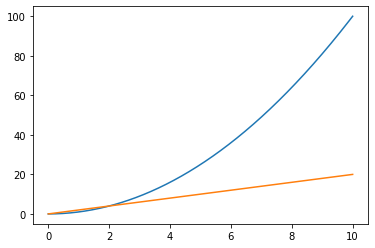

In [17]:
plt.plot(np.linspace(0,10,1000), np.array([t**2 for t in np.linspace(0,10,1000)]))
plt.plot(np.linspace(0,10,1000), np.gradient(np.array([t**2 for t in np.linspace(0,10,1000)]), np.linspace(0,10,1000)))

In [109]:
def genCoeffFunc(sub="D", coeff="Drag force"):
    return f"""
    @property
    def K{sub}(self):
        return self._K{sub}
    
    @K{sub}.setter
    def K{sub}(self, K{sub}):
        if np.isscalar(K{sub}):
            K{sub} = np.abs(K{sub})
            self._K{sub} = K{sub}
        else:
            raise TypeError("{coeff} coefficient K{sub} (AB) must be a scalar.")
            
    @property
    def C{sub}(self):
        return self.K2C(self.K{sub})
    
    @C{sub}.setter
    def C{sub}(self, C{sub}):
        if np.isscalar(C{sub}):
            C{sub} = np.abs(C{sub})
            self.K{sub} = self.C2K(C{sub})
        else:
            raise TypeError("{coeff} coefficient C{sub} (AD) must be a scalar.")"""

In [118]:
print(genCoeffFunc("XT", "Magnus cross moment"))


    @property
    def KXT(self):
        return self._KXT
    
    @KXT.setter
    def KXT(self, KXT):
        if np.isscalar(KXT):
            KXT = np.abs(KXT)
            self._KXT = KXT
        else:
            raise TypeError("Magnus cross moment coefficient KXT (AB) must be a scalar.")
            
    @property
    def CXT(self):
        return self.K2C(self.KXT)
    
    @CXT.setter
    def CXT(self, CXT):
        if np.isscalar(CXT):
            CXT = np.abs(CXT)
            self.KXT = self.C2K(CXT)
        else:
            raise TypeError("Magnus cross moment coefficient CXT (AD) must be a scalar.")


In [98]:
adb = AeroDB(cal=0.127)

In [99]:
adb.area

0.11255081953250026

In [103]:
adb.KD0 = 0.5
adb.KDa = 0.2

In [104]:
x = np.array([[5], [4], [10]])
v = np.array([[0.1], [0.2], [30]])
np.rad2deg(adb.yaw(x, v))

32.24463837795849

In [120]:
x.flatten().cross(v.flatten())

AttributeError: 'numpy.ndarray' object has no attribute 'cross'

In [105]:
adb.drag(x,v)

array([[ -0.04006435],
       [ -0.08012871],
       [-12.01930577]])

In [106]:
zen = ZENITH(0)

In [57]:
zen.x0 = np.array([1,1,1,0,0,0,0,0,0,0,0,0])

In [58]:
zen.xE

array([[[9.99999843e-01]],

       [[6.37815050e+06]],

       [[9.99999843e-01]]])

In [32]:
(zen.vel+np.zeros((3,1))).T

array([[0., 0., 0.]])

In [33]:
np.dot(zen.pos.flatten(),(zen.vel+np.zeros((3,1))).flatten())

0.0

In [24]:
zen.vel+np.zeros((3,1))

array([[0.],
       [0.],
       [0.]])

In [23]:
zen.yaw(np.zeros((3,1)))

ValueError: shapes (3,1) and (3,1) not aligned: 1 (dim 1) != 3 (dim 0)

In [6]:
np.arange(12).reshape((12,1))[6:9]

array([[6],
       [7],
       [8]])

In [ ]:
np.arct